In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F
import random
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy 

import predictive_coding as pc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'using {device}')

using cuda


In [3]:
n_train = 10000
n_val = 500
n_test = 2000
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: torch.flatten(x))])
dataset_train = datasets.MNIST('./data', download=True, train=True, transform=transform)
dataset_eval = datasets.MNIST('./data', download=True, train=False, transform=transform)

# Randomly sample the train dataset
train_dataset = torch.utils.data.Subset(dataset_train, random.sample(range(len(dataset_train)), n_train))

# Randomly sample the val dataset
val_dataset, test_dataset, not_used = torch.utils.data.random_split(dataset_eval, [n_val, n_test, dataset_eval.__len__()-n_val-n_test])

print(f'train: {len(train_dataset)}, val: {len(val_dataset)}, test: {len(test_dataset)}')

100%|██████████| 9912422/9912422 [00:00<00:00, 74529012.03it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 28881/28881 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw




100%|██████████| 1648877/1648877 [00:00<00:00, 82442945.83it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw

train: 10000, val: 500, test: 2000


PC reversed direction

In [4]:
input_size = 28*28
hidden_size = 256
hidden2_size = 128
output_size = 10

# activation_fn = nn.ReLU
activation_fn = nn.Tanh

def get_model(input_size, hidden_size, hidden2_size, output_size, activation_fn):
    return nn.Sequential(
        nn.Linear(input_size, hidden_size),
        pc.PCLayer(),
        activation_fn(),
        nn.Linear(hidden_size, hidden2_size),
        pc.PCLayer(),
        activation_fn(),
        nn.Linear(hidden2_size, output_size)
    )

pc_reversed = get_model(input_size, hidden_size, hidden2_size, output_size, activation_fn)
pc_reversed.train()
pc_reversed.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): PCLayer()
  (2): Tanh()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): PCLayer()
  (5): Tanh()
  (6): Linear(in_features=128, out_features=10, bias=True)
)

In [5]:
T = 50                             # number of inference iterations
update_x_at = 'all'                 # update latent state x at every iteration
optimizer_x_fn = optim.Adam         # optimizer for latent state x
optimizer_x_kwargs = {'lr': 0.1}    # optimizer parameters for latent state x
update_p_at = 'last'               # update parameters p at the last iteration
optimizer_p_fn = optim.Adam          # optimizer for parameters p
optimizer_p_kwargs = {'lr': 0.01, "weight_decay":0.05} # optimizer parameters for parameters p
plot_progress_at = []            # plot progress every inference iterations

trainer_reversed = pc.PCTrainer(pc_reversed, 
    T = T, 
    update_x_at = update_x_at, 
    optimizer_x_fn = optimizer_x_fn,
    optimizer_x_kwargs = optimizer_x_kwargs,
    update_p_at = update_p_at,   
    optimizer_p_fn = optimizer_p_fn,
    optimizer_p_kwargs = optimizer_p_kwargs,
    plot_progress_at= plot_progress_at,
)

def test_reversed(model, dataset, batch_size=1000):
    model.eval()
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
    correct = 0
    total = 0
    for data, label in test_loader:
        data, label = data.to(device), label.to(device)
        pred = model(data)
        _, predicted = torch.max(pred, -1)
        total += label.size(0)
        correct += (predicted == label).sum().item()
    model.train()
    return round(correct / total, 4)

Epoch 1: 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


Epoch 1 - Train acc: 0.125, Val acc: 0.13


Epoch 2: 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


Epoch 2 - Train acc: 0.292, Val acc: 0.298


Epoch 3: 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


Epoch 3 - Train acc: 0.3825, Val acc: 0.352


Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


Epoch 4 - Train acc: 0.4995, Val acc: 0.512


Epoch 5: 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


Epoch 5 - Train acc: 0.586, Val acc: 0.594


Epoch 6: 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


Epoch 6 - Train acc: 0.6905, Val acc: 0.71


Epoch 7: 100%|██████████| 10/10 [00:02<00:00,  3.48it/s]


Epoch 7 - Train acc: 0.6855, Val acc: 0.704


Epoch 8: 100%|██████████| 10/10 [00:02<00:00,  3.48it/s]


Epoch 8 - Train acc: 0.6705, Val acc: 0.668


Epoch 9: 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


Epoch 9 - Train acc: 0.7095, Val acc: 0.696


Epoch 10: 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


Epoch 10 - Train acc: 0.7485, Val acc: 0.76


Epoch 11: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


Epoch 11 - Train acc: 0.782, Val acc: 0.794


Epoch 12: 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


Epoch 12 - Train acc: 0.7875, Val acc: 0.796


Epoch 13: 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


Epoch 13 - Train acc: 0.79, Val acc: 0.784


Epoch 14: 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


Epoch 14 - Train acc: 0.78, Val acc: 0.782


Epoch 15: 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


Epoch 15 - Train acc: 0.808, Val acc: 0.774


Epoch 16: 100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


Epoch 16 - Train acc: 0.824, Val acc: 0.816


Epoch 17: 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


Epoch 17 - Train acc: 0.833, Val acc: 0.842


Epoch 18: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


Epoch 18 - Train acc: 0.8285, Val acc: 0.83


Epoch 19: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


Epoch 19 - Train acc: 0.822, Val acc: 0.84


Epoch 20: 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


Epoch 20 - Train acc: 0.813, Val acc: 0.84


Epoch 21: 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


Epoch 21 - Train acc: 0.8295, Val acc: 0.854


Epoch 22: 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


Epoch 22 - Train acc: 0.836, Val acc: 0.842


Epoch 23: 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


Epoch 23 - Train acc: 0.8425, Val acc: 0.836


Epoch 24: 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


Epoch 24 - Train acc: 0.846, Val acc: 0.848


Epoch 25: 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


Epoch 25 - Train acc: 0.8375, Val acc: 0.84


Epoch 26: 100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


Epoch 26 - Train acc: 0.8395, Val acc: 0.822


Epoch 27: 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


Epoch 27 - Train acc: 0.8335, Val acc: 0.818


Epoch 28: 100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


Epoch 28 - Train acc: 0.834, Val acc: 0.826


Epoch 29: 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


Epoch 29 - Train acc: 0.8325, Val acc: 0.846


Epoch 30: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


Epoch 30 - Train acc: 0.83, Val acc: 0.824


Epoch 31: 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


Epoch 31 - Train acc: 0.823, Val acc: 0.836


Epoch 32: 100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


Epoch 32 - Train acc: 0.8265, Val acc: 0.84


Epoch 33: 100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


Epoch 33 - Train acc: 0.8335, Val acc: 0.834


Epoch 34: 100%|██████████| 10/10 [00:02<00:00,  3.48it/s]


Epoch 34 - Train acc: 0.8355, Val acc: 0.84


Epoch 35: 100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


Epoch 35 - Train acc: 0.8405, Val acc: 0.846


Epoch 36: 100%|██████████| 10/10 [00:02<00:00,  3.48it/s]


Epoch 36 - Train acc: 0.8495, Val acc: 0.844


Epoch 37: 100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


Epoch 37 - Train acc: 0.848, Val acc: 0.84


Epoch 38: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


Epoch 38 - Train acc: 0.8475, Val acc: 0.844


Epoch 39: 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


Epoch 39 - Train acc: 0.846, Val acc: 0.842


Epoch 40: 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


Epoch 40 - Train acc: 0.843, Val acc: 0.854


Epoch 41: 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


Epoch 41 - Train acc: 0.8445, Val acc: 0.848


Epoch 42: 100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


Epoch 42 - Train acc: 0.831, Val acc: 0.838


Epoch 43: 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


Epoch 43 - Train acc: 0.847, Val acc: 0.854


Epoch 44: 100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


Epoch 44 - Train acc: 0.849, Val acc: 0.856


Epoch 45: 100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


Epoch 45 - Train acc: 0.8515, Val acc: 0.844


Epoch 46: 100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


Epoch 46 - Train acc: 0.8485, Val acc: 0.848


Epoch 47: 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


Epoch 47 - Train acc: 0.8575, Val acc: 0.836


Epoch 48: 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


Epoch 48 - Train acc: 0.8445, Val acc: 0.852


Epoch 49: 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


Epoch 49 - Train acc: 0.847, Val acc: 0.858


Epoch 50: 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


Epoch 50 - Train acc: 0.853, Val acc: 0.844
Test accuracy: 0.847


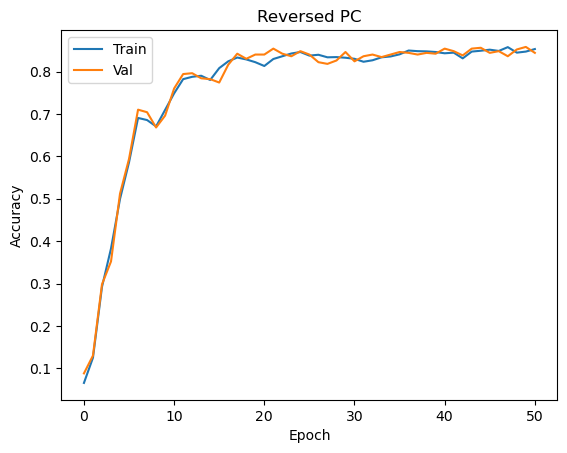

In [6]:
epochs = 50
batch_size = 1024
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

CE_loss = nn.CrossEntropyLoss()
loss_fn = lambda output, _target: CE_loss(output, _target)

best_val_acc = 0
best_model = copy.deepcopy(pc_reversed.state_dict())

train_acc = [test_reversed(pc_reversed, test_dataset)]
val_acc = [test_reversed(pc_reversed, val_dataset)]
for epoch in range(epochs):
    for data, label in tqdm(train_loader, desc=f'Epoch {epoch+1}'):
        data, label = data.to(device), label.to(device)
        trainer_reversed.train_on_batch(inputs=data, loss_fn=loss_fn, loss_fn_kwargs={'_target':label}, is_log_progress=False, is_return_results_every_t=False, is_checking_after_callback_after_t=False)
    train_acc.append(test_reversed(pc_reversed, test_dataset))
    val_acc.append(test_reversed(pc_reversed, val_dataset))
    if val_acc[-1] > best_val_acc:
        best_val_acc = val_acc[-1]
        best_model = copy.deepcopy(pc_reversed.state_dict())
    print(f'Epoch {epoch+1} - Train acc: {train_acc[-1]}, Val acc: {val_acc[-1]}')

    
test_model = get_model(input_size, hidden_size, hidden2_size, output_size, activation_fn)
test_model.load_state_dict(best_model, strict=False)
test_model.to(device)
acc_test = test_reversed(test_model, test_dataset)
print(f'Test accuracy: {acc_test}')


plt.plot(train_acc, label='Train')
plt.plot(val_acc, label='Val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Reversed PC with test accuracy: {acc_test}')

PC normal direction

In [7]:
input_size = 10
hidden_size = 256
hidden2_size = 256
output_size = 28*28

# activation_fn = nn.ReLU
activation_fn = nn.Tanh

pc_normal = get_model(input_size, hidden_size, hidden2_size, output_size, activation_fn)
pc_normal.train()
pc_normal.to(device)

def loss_fn_normal(output, _target):
    return 0.5*(output - _target).pow(2).sum()

In [8]:
T = 20                             # number of inference iterations
update_x_at = 'all'                 # update latent state x at every iteration
optimizer_x_fn = optim.SGD         # optimizer for latent state x
optimizer_x_kwargs = {'lr': 0.01}    # optimizer parameters for latent state x
update_p_at = 'last'                # update parameters p at the last iteration
optimizer_p_fn = optim.Adam          # optimizer for parameters p
optimizer_p_kwargs = {"lr": 0.001, "weight_decay":0., "betas":(0.9,0.999)} # optimizer parameters for parameters p
plot_progress_at = []            # plot progress every inference iterations

trainer_normal = pc.PCTrainer(pc_normal, 
    T = T, 
    update_x_at = update_x_at, 
    optimizer_x_fn = optimizer_x_fn,
    optimizer_x_kwargs = optimizer_x_kwargs,
    update_p_at = update_p_at,   
    optimizer_p_fn = optimizer_p_fn,
    optimizer_p_kwargs = optimizer_p_kwargs,
    plot_progress_at= plot_progress_at
)

# This class contains the parameters of the prior mean \mu parameter (see figure)
class BiasLayer(nn.Module):
    def __init__(self, out_features, offset=0.):
        super(BiasLayer, self).__init__()
        self.bias = nn.Parameter(offset*torch.ones(out_features) if offset is not None else 2*np.sqrt(out_features)*torch.rand(out_features)-np.sqrt(out_features), requires_grad=True)

    def forward(self, x):
        return torch.zeros_like(x) + self.bias  # return the prior mean \mu witht the same shape as the input x to make sure the batch size is the same


def test_normal(model, dataset, batch_size=1000):
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # add bias layer for inferece
    test_model = nn.Sequential(
        BiasLayer(10, offset=0.),
        pc.PCLayer(),
        model
    )
    test_model.train()
    test_model.to(device)

    # make pc_trainer for test_model   
    trainer_normal_test = pc.PCTrainer(test_model, 
        T = 100, 
        update_x_at = update_x_at, 
        optimizer_x_fn = optimizer_x_fn,
        optimizer_x_kwargs = optimizer_x_kwargs,
        update_p_at = "never",   
        optimizer_p_fn = optimizer_p_fn,
        optimizer_p_kwargs = optimizer_p_kwargs,
        plot_progress_at= plot_progress_at
    )

    correct_count, all_count = 0., 0.
    for data, labels in (test_loader):
        pseudo_input = torch.zeros(data.shape[0], 10)
        data, labels, pseudo_input = data.to(device), labels.to(device), pseudo_input.to(device)
        
        # MAP inference
        trainer_normal_test.train_on_batch(inputs=pseudo_input, loss_fn=loss_fn_normal, loss_fn_kwargs={'_target':data}, is_log_progress=False, is_return_results_every_t=False, is_checking_after_callback_after_t=False)
        pred = torch.max(test_model[1].get_x(), dim=1)
        correct = (pred.indices == labels).long()
        correct_count += correct.sum()
        all_count += correct.size(0)
    return round((correct_count / all_count).item(), 4)

Epoch 1: 100%|██████████| 20/20 [00:02<00:00,  7.48it/s]


Epoch 1 - Train acc: 0.73, Val acc: 0.754


Epoch 2: 100%|██████████| 20/20 [00:02<00:00,  7.47it/s]


Epoch 2 - Train acc: 0.782, Val acc: 0.786


Epoch 3: 100%|██████████| 20/20 [00:02<00:00,  7.50it/s]


Epoch 3 - Train acc: 0.8065, Val acc: 0.828


Epoch 4: 100%|██████████| 20/20 [00:02<00:00,  7.49it/s]


Epoch 4 - Train acc: 0.8195, Val acc: 0.842


Epoch 5: 100%|██████████| 20/20 [00:02<00:00,  7.51it/s]


Epoch 5 - Train acc: 0.82, Val acc: 0.848


Epoch 6: 100%|██████████| 20/20 [00:02<00:00,  7.51it/s]


Epoch 6 - Train acc: 0.832, Val acc: 0.844


Epoch 7: 100%|██████████| 20/20 [00:02<00:00,  6.88it/s]


Epoch 7 - Train acc: 0.832, Val acc: 0.846


Epoch 8: 100%|██████████| 20/20 [00:02<00:00,  7.51it/s]


Epoch 8 - Train acc: 0.8275, Val acc: 0.844


Epoch 9: 100%|██████████| 20/20 [00:02<00:00,  7.45it/s]


Epoch 9 - Train acc: 0.834, Val acc: 0.834


Epoch 10: 100%|██████████| 20/20 [00:02<00:00,  7.51it/s]


Epoch 10 - Train acc: 0.826, Val acc: 0.832
Test accuracy: 0.82


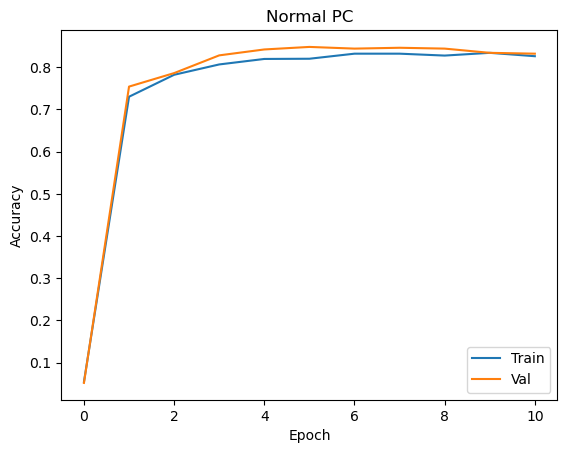

In [9]:
epochs = 10
batch_size = 500
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

best_val_acc = 0
best_model = copy.deepcopy(pc_normal.state_dict())

train_acc = [test_normal(pc_normal, test_dataset)]
val_acc = [test_normal(pc_normal, val_dataset)]
for epoch in range(epochs):
    for data, label in tqdm(train_loader, desc=f'Epoch {epoch+1}'):
        data, label = data.to(device), label.to(device)
        # labels to one-hot
        labels_one_hot = F.one_hot(label).float()
        trainer_normal.train_on_batch(inputs=labels_one_hot, loss_fn=loss_fn_normal, loss_fn_kwargs={'_target':data}, is_log_progress=False, is_return_results_every_t=False, is_checking_after_callback_after_t=False)
    train_acc.append(test_normal(pc_normal, test_dataset))
    val_acc.append(test_normal(pc_normal, val_dataset))
    if val_acc[-1] > best_val_acc:
        best_val_acc = val_acc[-1]
        best_model = copy.deepcopy(pc_normal.state_dict())
    print(f'Epoch {epoch+1} - Train acc: {train_acc[-1]}, Val acc: {val_acc[-1]}')

    
test_model = get_model(input_size, hidden_size, hidden2_size, output_size, activation_fn)
test_model.train()
test_model.load_state_dict(best_model, strict=False)
test_model.to(device)
acc_test = test_normal(test_model, test_dataset)
print(f'Test accuracy: {acc_test}')


plt.plot(train_acc, label='Train')
plt.plot(val_acc, label='Val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Normal PC with test accuracy: {acc_test}')

V -model: dual model with a generative 'image' model and a label decoder.

100%|██████████| 20/20 [00:03<00:00,  5.94it/s]


Train accuracy: 0.0425
Val accuracy: 0.038


100%|██████████| 20/20 [00:03<00:00,  6.00it/s]


Train accuracy: 0.197
Val accuracy: 0.194


100%|██████████| 20/20 [00:03<00:00,  5.98it/s]


Train accuracy: 0.9175
Val accuracy: 0.896


100%|██████████| 20/20 [00:03<00:00,  5.94it/s]


Train accuracy: 0.9175
Val accuracy: 0.896


100%|██████████| 20/20 [00:03<00:00,  6.00it/s]


Train accuracy: 0.6145
Val accuracy: 0.626


100%|██████████| 20/20 [00:03<00:00,  5.89it/s]


Train accuracy: 0.8755
Val accuracy: 0.876


100%|██████████| 20/20 [00:03<00:00,  5.98it/s]


Train accuracy: 0.952
Val accuracy: 0.93


100%|██████████| 20/20 [00:03<00:00,  6.00it/s]


Train accuracy: 1.0
Val accuracy: 1.0


100%|██████████| 20/20 [00:03<00:00,  5.94it/s]


Train accuracy: 1.0
Val accuracy: 1.0


100%|██████████| 20/20 [00:03<00:00,  5.98it/s]


Train accuracy: 1.0
Val accuracy: 1.0
Test accuracy: 1.0


Text(0.5, 1.0, 'PC-V model with test accuracy: {acc_test}')

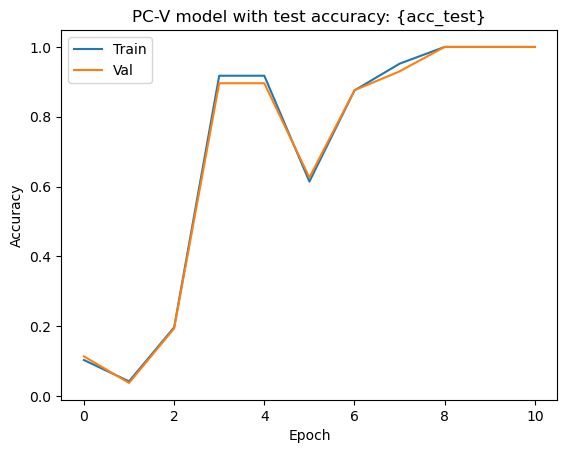

In [21]:
# set seed 
torch.manual_seed(0)

x_optm = optim.Adam
lr_x = 1e-1
p_optm = optim.Adam
lr_p =  1e-2
weight_decay = 0
activation_fns = nn.ReLU

input_size = 10
latent_size = 60
hidden_size = 256
hidden2_size = 256
output_size = 28*28


class PC_V_model(nn.Module):
    def __init__(self, input_size, latent_size, output_size, hidden_size, hidden2_size, activation_fn):
        super(PC_V_model, self).__init__()
        self.head = nn.Sequential(
            BiasLayer(latent_size, offset=None),
            pc.PCLayer(),
        )
        self.encoder = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            pc.PCLayer(),
            activation_fn(),
            nn.Linear(hidden_size, hidden2_size),
            pc.PCLayer(),
            activation_fn(),
            nn.Linear(hidden2_size, output_size)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, input_size),
        )
        
    def forward(self, x):
        latent = self.head(x)
        return torch.cat((self.encoder(latent), self.decoder(latent)), dim=1)


pc_v_model = PC_V_model(input_size, latent_size, output_size, hidden_size, hidden2_size, activation_fn)
pc_v_model.train()
pc_v_model.to(device)


def loss_fn_v_model(output, _image, _label):
    return 0.5*(output[:,:_image.shape[1]] - _image).pow(2).sum() + 0.1*CE_loss(output[:,_image.shape[1]:], _label)
T = 20                             # number of inference iterations
update_x_at = 'all'                 # update latent state x at every iteration
optimizer_x_fn = x_optm         # optimizer for latent state x
optimizer_x_kwargs = {'lr': lr_x}    # optimizer parameters for latent state x
update_p_at = 'last'                # update parameters p at the last iteration
optimizer_p_fn = p_optm         # optimizer for parameters p
optimizer_p_kwargs = {"lr": lr_p, "weight_decay":weight_decay} # optimizer parameters for parameters p
plot_progress_at = []            # plot progress every inference iterations

trainer_v_model = pc.PCTrainer(pc_v_model, 
    T = T, 
    update_x_at = update_x_at, 
    optimizer_x_fn = optimizer_x_fn,
    optimizer_x_kwargs = optimizer_x_kwargs,
    update_p_at = update_p_at,   
    optimizer_p_fn = optimizer_p_fn,
    optimizer_p_kwargs = optimizer_p_kwargs,
    plot_progress_at= plot_progress_at
)

# trainer_v_model.set_optimizer_p(optim.Adam(pc_v_model.decoder.parameters(), lr=0.0001, weight_decay=0.01, betas=(0.9,0.999)))

def test_v_model(model, dataset, batch_size=1000):
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # make pc_trainer for test_model   
    trainer_test = pc.PCTrainer(model, 
        T = 200, 
        update_x_at = update_x_at, 
        optimizer_x_fn = optimizer_x_fn,
        optimizer_x_kwargs = optimizer_x_kwargs,
        update_p_at = "never",   
        optimizer_p_fn = optimizer_p_fn,
        optimizer_p_kwargs = optimizer_p_kwargs,
        plot_progress_at= plot_progress_at
    )

    correct_count, all_count = 0., 0.
    for data, labels in (test_loader):
        pseudo_input = torch.zeros(data.shape[0], latent_size)
        data, labels, pseudo_input = data.to(device), labels.to(device), pseudo_input.to(device)
        labels_one_hot = F.one_hot(labels).float()
        # MAP inference
        results = trainer_test.train_on_batch(inputs=pseudo_input, loss_fn=loss_fn_v_model, loss_fn_kwargs={'_image':data, '_label':labels_one_hot}, is_log_progress=False, is_return_results_every_t=False, is_checking_after_callback_after_t=False, is_return_outputs=True)
        output = results["outputs"][-1]
        pred = torch.max(output[:, data.shape[1]:], dim=1)
        correct = (pred.indices == labels).long()
        correct_count += correct.sum()
        all_count += correct.size(0)
    return round((correct_count / all_count).item(), 4)
epochs = 10
batch_size = 512
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

best_val_acc = 0
best_model = copy.deepcopy(pc_v_model.state_dict())

train_acc = [test_v_model(pc_v_model, test_dataset)]
val_acc = [test_v_model(pc_v_model, val_dataset)]
for epoch in range(epochs):
    for data, labels in tqdm(train_loader):
        pseudo_input = torch.zeros(data.shape[0], latent_size)
        data, labels, pseudo_input = data.to(device), labels.to(device), pseudo_input.to(device)
        labels_one_hot = F.one_hot(labels).float()
        trainer_v_model.train_on_batch(inputs=pseudo_input, loss_fn=loss_fn_v_model, loss_fn_kwargs={'_image':data, '_label':labels_one_hot}, is_log_progress=False, is_return_results_every_t=False, is_checking_after_callback_after_t=False)
    train_acc.append(test_v_model(pc_v_model, test_dataset))
    val_acc.append(test_v_model(pc_v_model, val_dataset))
    print("Train accuracy:", train_acc[-1])
    print("Val accuracy:", val_acc[-1])
    if val_acc[-1] > best_val_acc:
        best_val_acc = val_acc[-1]
        best_model = copy.deepcopy(pc_v_model.state_dict())


test_model =  PC_V_model(input_size, latent_size, output_size, hidden_size, hidden2_size, activation_fn)
test_model.train()
test_model.load_state_dict(best_model, strict=False)
test_model.to(device)
acc_test = test_v_model(test_model, test_dataset)
print(f'Test accuracy: {acc_test}')

plt.plot(train_acc, label='Train')
plt.plot(val_acc, label='Val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('PC-V model with test accuracy: {acc_test}')


In [10]:

x_optm = [optim.Adam, optim.SGD]
lr_x = [1e-3, 1e-2, 1e-1, 1]
p_optm = [optim.Adam, optim.SGD]
lr_p = [1e-3, 1e-2, 1e-1, 1]
weight_decay = [0, 1e-3, 1e-2, 1e-1]
activation_fns = [nn.ReLU, nn.Tanh]
best_val_acc_tuning = 0
best_params = None

for lr_x_ in tqdm(lr_x):
    for lr_p_ in lr_p:
        for weight_decay_ in weight_decay:
            for optimizer_x_fn in x_optm:
                for optimizer_p_fn in p_optm:
                    for activation_fn_ in activation_fns:
                        input_size = 10
                        latent_size = 60
                        hidden_size = 256
                        hidden2_size = 256
                        output_size = 28*28

                        # activation_fn = nn.ReLU
                        # # activation_fn = nn.Tanh


                        class PC_V_model(nn.Module):
                            def __init__(self, input_size, latent_size, output_size, hidden_size, hidden2_size, activation_fn):
                                super(PC_V_model, self).__init__()
                                self.head = nn.Sequential(
                                    BiasLayer(latent_size, offset=None),
                                    pc.PCLayer(),
                                )
                                self.encoder = nn.Sequential(
                                    nn.Linear(latent_size, hidden_size),
                                    pc.PCLayer(),
                                    activation_fn(),
                                    nn.Linear(hidden_size, hidden2_size),
                                    pc.PCLayer(),
                                    activation_fn(),
                                    nn.Linear(hidden2_size, output_size)
                                )
                                self.decoder = nn.Sequential(
                                    nn.Linear(latent_size, input_size),
                                )
                                
                            def forward(self, x):
                                latent = self.head(x)
                                return torch.cat((self.encoder(latent), self.decoder(latent)), dim=1)


                        pc_v_model = PC_V_model(input_size, latent_size, output_size, hidden_size, hidden2_size, activation_fn)
                        pc_v_model.train()
                        pc_v_model.to(device)


                        def loss_fn_v_model(output, _image, _label):
                            return 0.5*(output[:,:_image.shape[1]] - _image).pow(2).sum() + 0.1*CE_loss(output[:,_image.shape[1]:], _label)
                        T = 20                             # number of inference iterations
                        update_x_at = 'all'                 # update latent state x at every iteration
                        optimizer_x_fn = optimizer_x_fn         # optimizer for latent state x
                        optimizer_x_kwargs = {'lr': lr_x_}    # optimizer parameters for latent state x
                        update_p_at = 'last'                # update parameters p at the last iteration
                        optimizer_p_fn = optimizer_p_fn         # optimizer for parameters p
                        optimizer_p_kwargs = {"lr": lr_p_, "weight_decay":weight_decay_} # optimizer parameters for parameters p
                        plot_progress_at = []            # plot progress every inference iterations

                        trainer_v_model = pc.PCTrainer(pc_v_model, 
                            T = T, 
                            update_x_at = update_x_at, 
                            optimizer_x_fn = optimizer_x_fn,
                            optimizer_x_kwargs = optimizer_x_kwargs,
                            update_p_at = update_p_at,   
                            optimizer_p_fn = optimizer_p_fn,
                            optimizer_p_kwargs = optimizer_p_kwargs,
                            plot_progress_at= plot_progress_at
                        )

                        # trainer_v_model.set_optimizer_p(optim.Adam(pc_v_model.decoder.parameters(), lr=0.0001, weight_decay=0.01, betas=(0.9,0.999)))

                        def test_v_model(model, dataset, batch_size=1000):
                            test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

                            # make pc_trainer for test_model   
                            trainer_test = pc.PCTrainer(model, 
                                T = 200, 
                                update_x_at = update_x_at, 
                                optimizer_x_fn = optimizer_x_fn,
                                optimizer_x_kwargs = optimizer_x_kwargs,
                                update_p_at = "never",   
                                optimizer_p_fn = optimizer_p_fn,
                                optimizer_p_kwargs = optimizer_p_kwargs,
                                plot_progress_at= plot_progress_at
                            )

                            correct_count, all_count = 0., 0.
                            for data, labels in (test_loader):
                                pseudo_input = torch.zeros(data.shape[0], latent_size)
                                data, labels, pseudo_input = data.to(device), labels.to(device), pseudo_input.to(device)
                                labels_one_hot = F.one_hot(labels).float()
                                # MAP inference
                                results = trainer_test.train_on_batch(inputs=pseudo_input, loss_fn=loss_fn_v_model, loss_fn_kwargs={'_image':data, '_label':labels_one_hot}, is_log_progress=False, is_return_results_every_t=False, is_checking_after_callback_after_t=False, is_return_outputs=True)
                                output = results["outputs"][-1]
                                pred = torch.max(output[:, data.shape[1]:], dim=1)
                                correct = (pred.indices == labels).long()
                                correct_count += correct.sum()
                                all_count += correct.size(0)
                            return round((correct_count / all_count).item(), 4)
                        epochs = 10
                        batch_size = 512
                        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

                        best_val_acc = 0
                        best_model = copy.deepcopy(pc_v_model.state_dict())

                        train_acc = [test_v_model(pc_v_model, test_dataset)]
                        val_acc = [test_v_model(pc_v_model, val_dataset)]
                        for epoch in range(epochs):
                            for data, labels in train_loader:
                                pseudo_input = torch.zeros(data.shape[0], latent_size)
                                data, labels, pseudo_input = data.to(device), labels.to(device), pseudo_input.to(device)
                                labels_one_hot = F.one_hot(labels).float()
                                trainer_v_model.train_on_batch(inputs=pseudo_input, loss_fn=loss_fn_v_model, loss_fn_kwargs={'_image':data, '_label':labels_one_hot}, is_log_progress=False, is_return_results_every_t=False, is_checking_after_callback_after_t=False)
                            train_acc.append(test_v_model(pc_v_model, test_dataset))
                            val_acc.append(test_v_model(pc_v_model, val_dataset))
                            if val_acc[-1] > best_val_acc:
                                best_val_acc = val_acc[-1]
                                best_model = copy.deepcopy(pc_v_model.state_dict())
                            # print(f'Epoch {epoch+1} - Train acc: {train_acc[-1]}, Val acc: {val_acc[-1]}')

                        if best_val_acc > best_val_acc_tuning:
                            print(f'Best val acc: {best_val_acc}, Best params: "lr_x": {lr_x_}, "lr_p": {lr_p_}, "weight_decay": {weight_decay_}, "activation_fn": {activation_fn_}, "optimizer_x_fn": {optimizer_x_fn}, "optimizer_p_fn": {optimizer_p_fn}')
                            best_val_acc_tuning = best_val_acc
                            best_params = {"lr_x": lr_x_, "lr_p": lr_p_, "weight_decay": weight_decay_}

print(f'Best val acc: {best_val_acc_tuning}, Best params: {best_params}')

  0%|          | 0/4 [00:00<?, ?it/s]

Best val acc: 0.158, Best params: "lr_x": 0.001, "lr_p": 0.001, "weight_decay": 0, "activation_fn": <class 'torch.nn.modules.activation.ReLU'>, "optimizer_x_fn": <class 'torch.optim.adam.Adam'>, "optimizer_p_fn": <class 'torch.optim.adam.Adam'>
Best val acc: 0.17, Best params: "lr_x": 0.001, "lr_p": 0.001, "weight_decay": 0, "activation_fn": <class 'torch.nn.modules.activation.Tanh'>, "optimizer_x_fn": <class 'torch.optim.adam.Adam'>, "optimizer_p_fn": <class 'torch.optim.adam.Adam'>
Best val acc: 0.172, Best params: "lr_x": 0.001, "lr_p": 0.001, "weight_decay": 0.001, "activation_fn": <class 'torch.nn.modules.activation.ReLU'>, "optimizer_x_fn": <class 'torch.optim.adam.Adam'>, "optimizer_p_fn": <class 'torch.optim.adam.Adam'>
Best val acc: 0.268, Best params: "lr_x": 0.001, "lr_p": 0.1, "weight_decay": 0.001, "activation_fn": <class 'torch.nn.modules.activation.ReLU'>, "optimizer_x_fn": <class 'torch.optim.sgd.SGD'>, "optimizer_p_fn": <class 'torch.optim.adam.Adam'>


 25%|██▌       | 1/4 [2:14:29<6:43:29, 8069.68s/it]

Best val acc: 0.302, Best params: "lr_x": 0.01, "lr_p": 0.1, "weight_decay": 0, "activation_fn": <class 'torch.nn.modules.activation.Tanh'>, "optimizer_x_fn": <class 'torch.optim.sgd.SGD'>, "optimizer_p_fn": <class 'torch.optim.adam.Adam'>


 50%|█████     | 2/4 [4:28:55<4:28:55, 8067.60s/it]

Best val acc: 0.344, Best params: "lr_x": 0.1, "lr_p": 0.001, "weight_decay": 0, "activation_fn": <class 'torch.nn.modules.activation.ReLU'>, "optimizer_x_fn": <class 'torch.optim.adam.Adam'>, "optimizer_p_fn": <class 'torch.optim.adam.Adam'>
Best val acc: 0.972, Best params: "lr_x": 0.1, "lr_p": 0.01, "weight_decay": 0, "activation_fn": <class 'torch.nn.modules.activation.ReLU'>, "optimizer_x_fn": <class 'torch.optim.adam.Adam'>, "optimizer_p_fn": <class 'torch.optim.adam.Adam'>


 75%|███████▌  | 3/4 [6:43:21<2:14:26, 8066.93s/it]

Best val acc: 1.0, Best params: "lr_x": 1, "lr_p": 0.01, "weight_decay": 0.001, "activation_fn": <class 'torch.nn.modules.activation.Tanh'>, "optimizer_x_fn": <class 'torch.optim.adam.Adam'>, "optimizer_p_fn": <class 'torch.optim.adam.Adam'>


100%|██████████| 4/4 [8:57:49<00:00, 8067.44s/it]  

Best val acc: 1.0, Best params: {'lr_x': 1, 'lr_p': 0.01, 'weight_decay': 0.001}
